# Instructions
<strong>DRILL: Improve this gradient boost model</strong>

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement. Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set. Strategies you might use include:

- Creating new features
- Applying more overfitting-prevention strategies like subsampling
- More iterations
- Trying a different loss function
- Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

In [111]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# Load and clean

In [268]:
raw_df = pd.read_csv(
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")
print(raw_df.shape)
raw_df.head()

(8594, 13)


,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


Let's check our nulls and our country counts:

In [269]:
raw_df.isnull().sum()

cntry        0
idno         0
year         0
tvtot        8
ppltrst     14
pplfair     39
pplhlp      25
happy       31
sclmeet     15
sclact      94
gndr        10
agea       239
partner     17
dtype: int64

In [270]:
raw_df.cntry.value_counts()

ES    2426
SE    1816
CH    1546
NO    1462
CZ    1316
DE      28
Name: cntry, dtype: int64

In [271]:
# Nulls: Dropping a couple hundred out of 8600 rows is no biggie.  
# Let's drop those - and the unnecessary ID number and year columns, while we're at it.
happiness_df = raw_df.dropna().copy()
happiness_df.drop(['idno', 'year'], axis=1, inplace=True)

# And let's convert partner to a Boolean rather than 1 or 2.
happiness_df['partner'] = happiness_df['partner']==1.0

# Because we've got just 28 people from Germany (compared to at least 1200 from every other country here) 
# let's drop Germany.
happiness_df = happiness_df[happiness_df['cntry']!='DE']

# Let's make gender a -1 / +1 binary (useful for multiplying columns for feature generation later):
happiness_df['gndr'] = (happiness_df['gndr']*2 - 3).astype(int)

# And we'll convert our countries into dummy variables later, when we do our train/test splits.
happiness_df.head()

,cntry,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,3.0,3.0,10.0,5.0,8.0,5.0,4.0,1,60.0,True
1,CH,6.0,5.0,7.0,5.0,9.0,3.0,2.0,1,59.0,True
2,CH,1.0,8.0,8.0,8.0,7.0,6.0,3.0,-1,24.0,False
3,CH,4.0,6.0,6.0,7.0,10.0,6.0,2.0,1,64.0,True
4,CH,5.0,6.0,7.0,5.0,8.0,7.0,2.0,1,55.0,True


# Preliminary RF and boosted RT models

In [289]:
from sklearn.model_selection import train_test_split
X = pd.get_dummies(happiness_df.drop('partner', axis=1), columns=['cntry'])
y = happiness_df['partner']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [108]:
from sklearn.metrics import confusion_matrix
def show_conf_mat(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plt.figure(figsize=(5,5))
    conf_mat = np.round(confusion_matrix(y_test, y_pred)/len(y_test), 2)
    sns.heatmap(conf_mat, square=True, annot=True, annot_kws={'size':16}, cmap='RdBu_r', center=0, fmt='g')
    plt.title('confusion matrix (by percentage)')
    plt.show()

First, a basic random forest, aka random tree + bagging:

[0.72722797 0.68374384 0.7226601  0.71907344] 
 mean:  0.7131763356488511


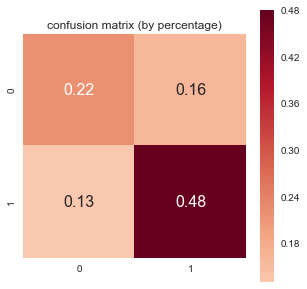

In [298]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

rfc = RandomForestClassifier()
cv_score = cross_val_score(rfc, X, y, cv=4)
print(cv_score, '\n mean: ', np.mean(cv_score))

show_conf_mat(rfc)

Not bad.  And now for a basic RT + boosting model:

CV scores: [0.76415559 0.73990148 0.75123153 0.7555446 ] 
 mean:  0.7527082991397627
Train score:  0.7793103448275862
Test score:  0.7536945812807881


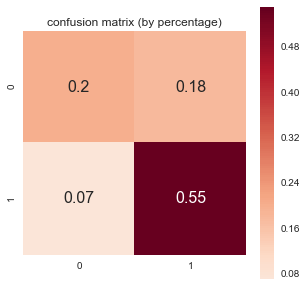

In [291]:
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}
# set random state!

gbc_1 = ensemble.GradientBoostingClassifier(**params)
cv_score = cross_val_score(gbc_1, X, y, cv=4)
gbc_1.fit(X_train, y_train)
train_score = gbc_1.score(X_train, y_train)
test_score = gbc_1.score(X_test, y_test)

print("CV scores:", cv_score, '\n mean: ', np.mean(cv_score))
print("Train score: ", train_score)
print("Test score: ", test_score)

show_conf_mat(gbc_1)

About the same.  If we tinker with the parameters a bit (I've omitted the tinkering for sake of space), we see that we tend to overfit if we increase the depth of the trees.  Doubling or quadrupling the number of trees/estimators also leads to overfitting (albeit not as severe) with no true accuracy improvement.  Let's what a basic hyperparamter search turns up:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from time import time
param_dist = {
    'loss': ['deviance','exponential'],
    'n_estimators': [300,500,1000,2000],
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5],
    'max_depth': [2,4,6,8],
    'max_features': [2,4,6,8]
}

random_search = RandomizedSearchCV(gbc_1, param_distributions=param_dist,
                                   n_iter=30)
start = time()
random_search.fit(X_train, y_train)
print("Elapsed seconds: ", time()-start)

In [118]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
report(random_search.cv_results_, n_top=3)

Model with rank: 1
Mean validation score: 0.755 (std: 0.000)
Parameters: {'n_estimators': 300, 'max_features': 8, 'max_depth': 2, 'loss': 'deviance', 'learning_rate': 0.1}

Model with rank: 2
Mean validation score: 0.752 (std: 0.004)
Parameters: {'n_estimators': 500, 'max_features': 8, 'max_depth': 6, 'loss': 'deviance', 'learning_rate': 0.01}

Model with rank: 3
Mean validation score: 0.751 (std: 0.004)
Parameters: {'n_estimators': 300, 'max_features': 6, 'max_depth': 2, 'loss': 'exponential', 'learning_rate': 0.3}



In short, it looks like toggling the parameters isn't making much difference here: we can get more or less overfitting (with little effect on accuracy), but our accuracy maxes out around 0.75.  Finally, a quick look at AdaBoost:

CV scores: [0.75824717 0.73596059 0.7364532  0.74420897] 
 mean:  0.7437174829804253
Train score:  0.755008210180624
Test score:  0.7453201970443349


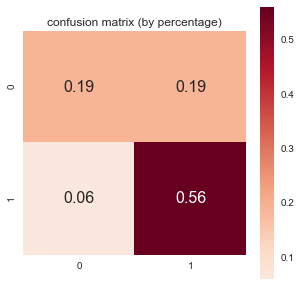

In [290]:
from sklearn.ensemble import AdaBoostClassifier

ada = ensemble.AdaBoostClassifier()
cv_score = cross_val_score(ada, X, y, cv=4)
ada.fit(X_train, y_train)
train_score = ada.score(X_train, y_train)
test_score = ada.score(X_test, y_test)

print("CV scores:", cv_score, '\n mean: ', np.mean(cv_score))
print("Train score: ", train_score)
print("Test score: ", test_score)

show_conf_mat(ada)

Same results.  We're stuck at 0.75 accuracy no matter what we do with this data.  Let's try some feature engineering.

# Feature engineering

As an experiment here, I'm going to generate several new dataframes of featuresets to try running our models on:
- <b>happiness_df</b>: the original features
- <b>relative_df</b>: all of the original features scaled to the means of their respective countries
- <b>combo_df</b>: the original features plus all combinations of original features
- <b>combo_2_df</b>: the original features plus squared features plus all combinations
- <b>rel_combo_df</b>: the country-mean-scaled features plus all combinations of original features
- <b>rel_combo_2_df</b>: the country-mean-scaled features plus squared features plus all combinations
- <b>combo_2_pca_df</b>: the original features plus squared features plus all combinations, run through PCA to reduce to 15 component features

My strategy here is basically:
- generate a bunch of relative, combinatoric, and/or polynomial features
- test models on these datasets
- shrink features by selecting top feature_importances, and by running PCA

In [150]:
happiness_df.head()

,cntry,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,True
1,CH,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,True
2,CH,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,False
3,CH,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,True
4,CH,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,True


In [272]:
relative_df = happiness_df.copy()
for col_name in relative_df.columns[1:10]: # excludes country, partner
    cntry_means = relative_df.groupby('cntry')[col_name].agg(np.mean)
    cntry_means_col = [cntry_means[cntry] for cntry in relative_df['cntry']]
    relative_df[col_name] = relative_df[col_name] / cntry_means_col
relative_df.head()

,cntry,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,0.975314,0.523979,1.595457,0.879442,0.986045,0.970906,1.455712,44.69697,1.285683,True
1,CH,1.950628,0.873298,1.116820,0.879442,1.109301,0.582543,0.727856,44.69697,1.264255,True
2,CH,0.325105,1.397276,1.276366,1.407107,0.862789,1.165087,1.091784,-44.69697,0.514273,False
3,CH,1.300419,1.047957,0.957274,1.231219,1.232556,1.165087,0.727856,44.69697,1.371395,True
4,CH,1.625523,1.047957,1.116820,0.879442,0.986045,1.359268,0.727856,44.69697,1.178543,True


In [294]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=1,include_bias=False)
combo_df = pd.DataFrame(poly.fit_transform(happiness_df.drop(['cntry', 'partner'], axis=1)))
# combo_df['cntry'] = happiness_df['cntry'].copy() # THIS CAUSES INDEX ERRORS - ???
combo_df.head()

,0,1,2,3,4,5,6,7,8
0,3.0,3.0,10.0,5.0,8.0,5.0,4.0,1.0,60.0
1,6.0,5.0,7.0,5.0,9.0,3.0,2.0,1.0,59.0
2,1.0,8.0,8.0,8.0,7.0,6.0,3.0,-1.0,24.0
3,4.0,6.0,6.0,7.0,10.0,6.0,2.0,1.0,64.0
4,5.0,6.0,7.0,5.0,8.0,7.0,2.0,1.0,55.0


In [295]:
poly = PolynomialFeatures(degree=2,include_bias=False)
combo_2_df = pd.DataFrame(poly.fit_transform(happiness_df.drop(['cntry', 'partner'], axis=1)))
# combo_df['cntry'] = happiness_df['cntry'].copy() # THIS CAUSES INDEX ERRORS - ???
combo_2_df.head()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,3.0,3.0,10.0,5.0,8.0,5.0,4.0,1.0,60.0,9.0,...,25.0,20.0,5.0,300.0,16.0,4.0,240.0,1.0,60.0,3600.0
1,6.0,5.0,7.0,5.0,9.0,3.0,2.0,1.0,59.0,36.0,...,9.0,6.0,3.0,177.0,4.0,2.0,118.0,1.0,59.0,3481.0
2,1.0,8.0,8.0,8.0,7.0,6.0,3.0,-1.0,24.0,1.0,...,36.0,18.0,-6.0,144.0,9.0,-3.0,72.0,1.0,-24.0,576.0
3,4.0,6.0,6.0,7.0,10.0,6.0,2.0,1.0,64.0,16.0,...,36.0,12.0,6.0,384.0,4.0,2.0,128.0,1.0,64.0,4096.0
4,5.0,6.0,7.0,5.0,8.0,7.0,2.0,1.0,55.0,25.0,...,49.0,14.0,7.0,385.0,4.0,2.0,110.0,1.0,55.0,3025.0


In [296]:
poly = PolynomialFeatures(degree=2,include_bias=False)
rel_combo_2_df = pd.DataFrame(poly.fit_transform(relative_df.drop(['cntry', 'partner'], axis=1)))
# combo_df['cntry'] = happiness_df['cntry'].copy() # THIS CAUSES INDEX ERRORS - ???

In [297]:
from sklearn.decomposition import PCA
X_train, X_test, y_train, y_test = train_test_split(combo_2_df, happiness_df['partner'], test_size=0.25)
pca = PCA(n_components=12)
pca.fit(X_train)
Xpc_train = pca.transform(X_train)
Xpc_test = pca.transform(X_test)

In [ ]:
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

gbc_pca = ensemble.GradientBoostingClassifier(**params)
cv_score = cross_val_score(gbc_pca, X, y, cv=4)
gbc_pca.fit(Xpc_train, y_train)
train_score = gbc_pca.score(X_train, y_train)
test_score = gbc_pca.score(Xpc_test, y_test)

print("CV scores:", cv_score, '\n mean: ', np.mean(cv_score))
print("Train score: ", train_score)
print("Test score: ", test_score)

# Initial Take (scratch)

In [228]:

# for col_name in happiness_df.columns[1:10]: # excludes country, partner
#     cntry_means = happiness_df.groupby('cntry')[col_name].agg(np.mean)
#     happiness_df['relative_'+col_name] = happiness_df[col_name] / cntry_means[happiness_df['cntry']]
# DOESN'T WORK BECAUSE OF SOME INDEXING BULLSHIT

# First, every score is probably more important relative to fellow citizens than to other EU countries
# (what makes us happy is sometimes not what we have, but what we have compared to the Joneses)
for col_name in happiness_df.columns[1:10]: # excludes country, partner
    cntry_means = happiness_df.groupby('cntry')[col_name].agg(np.mean)
    cntry_means_col = [cntry_means[cntry] for cntry in happiness_df['cntry']]
    happiness_df['relative_'+col_name] = happiness_df[col_name] / cntry_means_col

# tvtot may be different based on happiness, and based on social interactions
happy_scaled = (happiness_df['happy'] - np.mean(happiness_df.happy)) / 10
sclmeet_scaled = (happiness_df['sclmeet'] - np.mean(happiness_df.sclmeet)) / 10
happiness_df['tv_happ'] = happiness_df['tvtot'] * happy_scaled
happiness_df['tv_soc'] = happiness_df['tvtot'] * sclmeet_scaled

# age and happiness are likely to have a significant interaction - older singles are probably less likely
# to be happy single than people in their 20s
happiness_df['age_happ'] = (happiness_df['agea'] - np.mean(happiness_df.agea)) * happiness_df.happy

# finally, number of social activities interacting with gender and age may predict partner
# note: subtracting 1.5 from gndr makes it a binary -0.5 and 0.5
happiness_df['gender_sclact'] = (happiness_df['gndr'] * happiness_df['sclact']) 
# multiply 

# and finally, let's try correlating gender with all other features
happiness_df.head()

,cntry,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,...,relative_pplhlp,relative_happy,relative_sclmeet,relative_sclact,relative_gndr,relative_agea,tv_happ,tv_soc,age_happ,gender_sclact
0,CH,3.0,3.0,10.0,5.0,8.0,5.0,4.0,1,60.0,...,0.879442,0.986045,0.970906,1.455712,44.69697,1.285683,0.087340,-0.065320,102.160591,4.0
1,CH,6.0,5.0,7.0,5.0,9.0,3.0,2.0,1,59.0,...,0.879442,1.109301,0.582543,0.727856,44.69697,1.264255,0.774680,-1.330640,105.930665,2.0
2,CH,1.0,8.0,8.0,8.0,7.0,6.0,3.0,-1,24.0,...,1.407107,0.862789,1.165087,1.091784,-44.69697,0.514273,-0.070887,0.078227,-162.609483,-3.0
3,CH,4.0,6.0,6.0,7.0,10.0,6.0,2.0,1,64.0,...,1.231219,1.232556,1.165087,0.727856,44.69697,1.371395,0.916453,0.312906,167.700739,2.0
4,CH,5.0,6.0,7.0,5.0,8.0,7.0,2.0,1,55.0,...,0.879442,0.986045,1.359268,0.727856,44.69697,1.178543,0.145567,0.891133,62.160591,2.0


Now let's winnow them down using feature importance testing:

In [255]:
X = pd.get_dummies(happiness_df.drop('partner', axis=1), columns=['cntry'])
y = happiness_df['partner']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Train score:  0.8853858784893268 
Test score:  0.7527093596059113


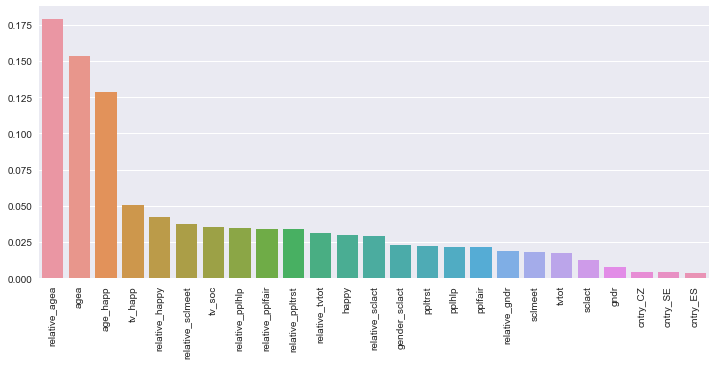

In [256]:
rfc_2 = RandomForestClassifier(n_estimators=100, max_depth=12)
rfc_2.fit(X_train, y_train)
train_score = rfc_2.score(X_train, y_train)
test_score = rfc_2.score(X_test, y_test)
print("Train score: ", train_score, "\nTest score: ", test_score)
labeled_fi = sorted( list(zip(X_train.columns, rfc_2.feature_importances_)), key=lambda x: -x[1])
plt.figure(figsize=(12,5))
x_imp = [tup[0] for tup in labeled_fi[:25]]
y_labels = [tup[1] for tup in labeled_fi[:25]]
plt.xticks(rotation=90)
sns.barplot(x_imp, y_labels);

On an initial look, it seems we've got more overfitting but no more accuracy.  What's surprising here to me is that there's no accuracy gain even though nine of the ten most important features are engineered features.  I would think that generating new features more predictively important than the old features would entail an accuracy gain.  Why doesn't it?

In [257]:
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

gbc_1 = ensemble.GradientBoostingClassifier(**params)
cv_score = cross_val_score(gbc_1, X, y, cv=4)
gbc_1.fit(X_train, y_train)
train_score = gbc_1.score(X_train, y_train)
test_score = gbc_1.score(X_test, y_test)

print("CV scores:", cv_score, '\n mean: ', np.mean(cv_score))
print("Train score: ", train_score)
print("Test score: ", test_score)

CV scores: [0.75677006 0.73891626 0.74630542 0.74322326] 
 mean:  0.7463037503939265
Train score:  0.7937602627257799
Test score:  0.7527093596059113


[0.61447563 0.66555802 0.72690318] 
 mean:  0.6689789417029393


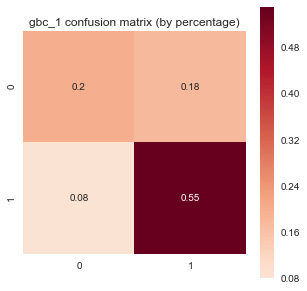

In [95]:
params = {'n_estimators': 5000,
          'max_depth': 2,
          'loss': 'deviance'}

gbc_2 = ensemble.GradientBoostingClassifier(**params)
cv_score = cross_val_score(gbc_2, X, y, cv=4)
print(cv_score, '\n mean: ', np.mean(cv_score))

show_conf_mat(gbc_2)

[0.62075332 0.70879527 0.72764228] 
 mean:  0.6857302898932037


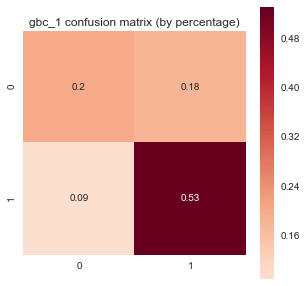

In [97]:
params = {'n_estimators': 500,
          'max_depth': 8,
          'loss': 'exponential'}

gbc_3 = ensemble.GradientBoostingClassifier(**params)
cv_score = cross_val_score(gbc_3, X, y, cv=3)
print(cv_score, '\n mean: ', np.mean(cv_score))

show_conf_mat(gbc_3)